In [2]:
from typing import Dict,List
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
from hierataxo.plot_taxotree import (
    order_manager,configure_rcParams,
    standard_classification_view)
c_rcParams=configure_rcParams()

In [15]:
preds={}
for seed in [7,11,42,77,10043]:
    preds[f'{seed}']=pd.read_pickle(f'infer/reload_ckpt/seed-{seed}.pkl')
preds['exp7']=pd.read_pickle('infer/reload_ckpt/lightning_exp7-normal.pkl')

In [16]:

def fetch_pred_dist(s:pd.Series):
    return [torch.tensor([s[f'{i}_predict']]) for i in order_manager.level_names]

def distribution_to_color_dict(s:pd.Series)->Dict[str,tuple]:
    p=fetch_pred_dist(s)
    return order_manager.distribution_to_color_dict(p)

def taxo_label_to_color_dict(s:pd.Series)->Dict[str,tuple]:
    return order_manager.distribution_to_color_dict(
        order_manager.order_to_onehot(s['taxo_label']))
    
def to_prob_tensors(pred:pd.DataFrame)->Dict[str,torch.Tensor]:
    o={f'{i}_gt':[] for i in order_manager.level_names}
    o.update({f'{i}_pred':[] for i in order_manager.level_names})
    for _,s in pred.iterrows():
        gts=order_manager.order_to_onehot(s['taxo_label'])
        preds=fetch_pred_dist(s)
        for level,gt,p in zip(order_manager.level_names,gts,preds):
            o[f'{level}_gt'].append(gt)
            o[f'{level}_pred'].append(p)
    for k,v in o.items():
        o[k]=torch.concat(v)
    return o

def cal_acc(pred:pd.DataFrame):
    prob_tensors=to_prob_tensors(pred)
    o={}
    for level in order_manager.level_names:
        o[f'{level}-acc']=torch.sum(torch.argmax(prob_tensors[f'{level}_pred'],dim=1
            )==torch.argmax(prob_tensors[f'{level}_gt'],dim=1)).item()/len(pred)
    return o

In [17]:
for i in preds.values():
    print(cal_acc(i))

{'Kingdom-acc': 0.9965465465465465, 'Phylum-acc': 0.9929429429429429, 'Class-acc': 0.9842342342342343, 'Order-acc': 0.9794294294294295}
{'Kingdom-acc': 0.9990990990990991, 'Phylum-acc': 0.9917417417417418, 'Class-acc': 0.9905405405405405, 'Order-acc': 0.9792792792792793}
{'Kingdom-acc': 0.9966966966966967, 'Phylum-acc': 0.987987987987988, 'Class-acc': 0.978978978978979, 'Order-acc': 0.9704204204204204}
{'Kingdom-acc': 0.996996996996997, 'Phylum-acc': 0.9900900900900901, 'Class-acc': 0.9912912912912913, 'Order-acc': 0.9905405405405405}
{'Kingdom-acc': 0.9945945945945946, 'Phylum-acc': 0.9803303303303303, 'Class-acc': 0.972072072072072, 'Order-acc': 0.9623123123123123}
{'Kingdom-acc': 0.9957957957957958, 'Phylum-acc': 0.9962462462462462, 'Class-acc': 0.9917417417417418, 'Order-acc': 0.9891891891891892}


TODO  
predict cols -> true label cols  
for every entry: mean/std -> scatter plot  
identify the "always pool" entry  
ICTV new genbank entries  
single domain's t-SNE  



In [18]:
# s=preds[77].loc[0]
def order_truelabel_prob(s:pd.Series)->float:
    return torch.softmax(torch.tensor(s['Order_predict']),dim=0)[s['taxo'][-1]].item()
for i in preds.values():
    i['Order-true-prob']=i.apply(order_truelabel_prob,axis=1)

In [31]:
# from collections import defaultdict
# probs=defaultdict(list)
# for i in preds.values():
probs=pd.DataFrame()
for k,v in preds.items():
    probs[k]=v.set_index('name')['Order-true-prob']
probs['mean'],probs['std'],probs['true-rate']=probs.mean(axis=1),probs.std(axis=1),probs.apply(lambda x:sum([i>0.9 for i in x]),axis=1)

In [52]:
from matplotlib.colors import LinearSegmentedColormap,to_rgb
cmap=LinearSegmentedColormap.from_list('tmp',[to_rgb('#f10c45'),to_rgb('#a3a3a3')],N=6)

<Axes: xlabel='mean', ylabel='std'>

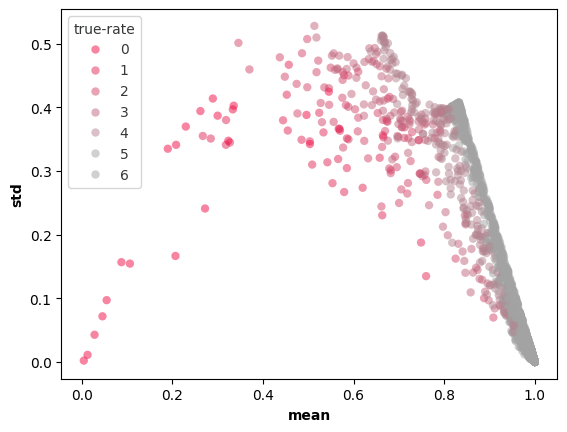

In [54]:
sns.scatterplot(probs,x='mean',y='std',hue='true-rate',linewidth=0,alpha=0.5,palette=cmap) #sns.color_palette("crest", as_cmap=True)

In [59]:
failed_cases=probs[probs['true-rate']<2].index

In [61]:
pred=preds['exp7']
pred:pd.DataFrame
failed_pred=pred[pred['name'].isin(failed_cases)]

/tmp/ipykernel_102475/334711166.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([i.replace('virales','-') for i in _.keys()],


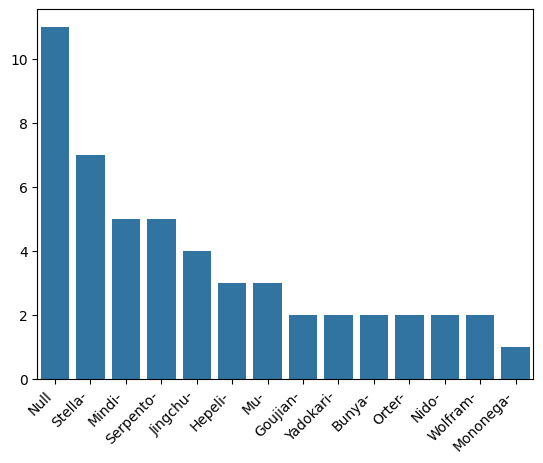

In [74]:
_=failed_pred['taxo_label'].apply(lambda x:x[-1]).value_counts()
plt.close()
fig,ax=plt.subplots(1,1)
sns.barplot(x=[i.replace('virales','-') for i in _.keys()],y=_.values,ax=ax)
ax.set_xticklabels([i.replace('virales','-') for i in _.keys()],
    rotation=45,
    horizontalalignment='right',
    verticalalignment='top')
plt.show()

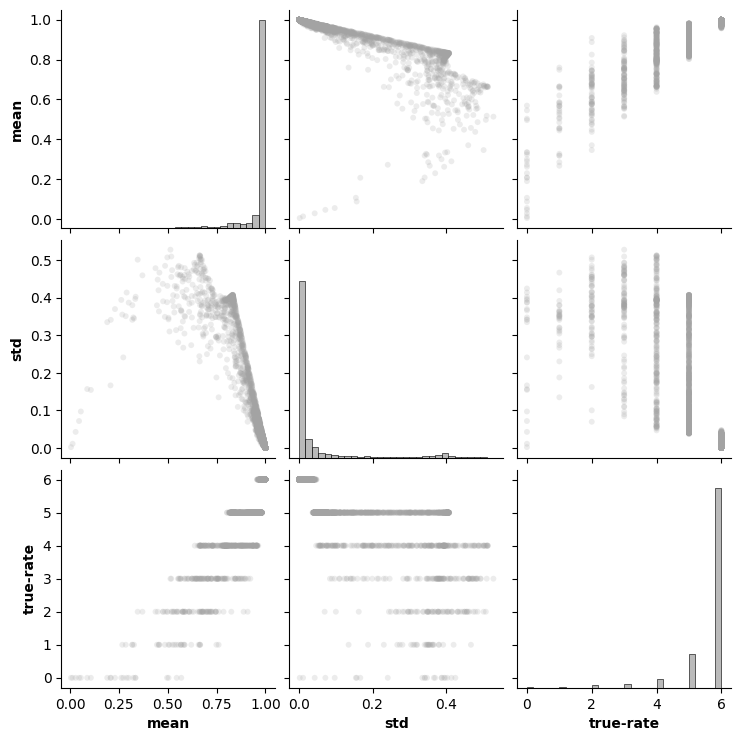

In [34]:
sns.pairplot(probs[['mean','std','true-rate']],plot_kws=dict(linewidth=0,alpha=0.2,size=0.5,color='#a3a3a3'),diag_kws=dict(color='#a3a3a3',bins=30))

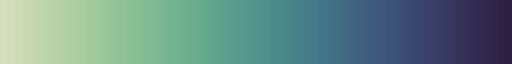

In [36]:
sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

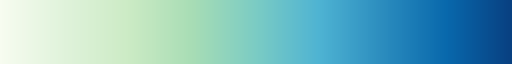

In [39]:
sns.color_palette("GnBu", as_cmap=True)

<Axes: >

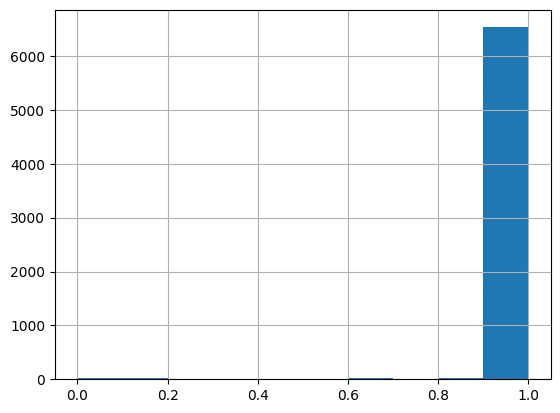

In [14]:
preds[77].apply(order_truelabel_prob,axis=1).hist()